# Изучение свойств опционов. Часть 1.

## Цель задания:
### 1. Получить навык работы с биржевой информацией CBOE 
### 2. Изучить свойства моделей CRR и BSM
### 3. Построить простые опционные стратегии
### 4. Сравнить теоретические и рыночные цены опционов
### 5. Изучить показатель чувствительности дельта и построить реплицированный портфель
### 6. Изучить показатель чувствительности вега и рассчитать подразумеваемую волатильность

### В прилагаемом файле содержится информация об опционах на акции трех американских компаний - Apple, Microsoft и Exxon Mobile

### Рекомендуемая литература:
### 1.Y.Hilpish "Derivatives Analytics with Python"
### 2.Y.Hilpish  "Python for Finance"
### 3.J.M. Weiming "Mastering Python for Finance"

## 1. Загрузка библиотек

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
from datetime import datetime, timedelta

In [5]:
from __future__ import division

In [6]:
import networkx as nx  # библиотеке визуализации графов

In [7]:
import matplotlib.pyplot as plt  # графическая библиотека

%matplotlib inline

## 2. Загрузка и подготовка данных

### Данные по опционам

In [8]:
cboe_options = pd.read_csv("UnderlyingOptionsEODCalcs_2019-02-04.csv", parse_dates=True)

In [9]:
cboe_options.columns

Index(['underlying_symbol', 'quote_date', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
       'underlying_bid_1545', 'underlying_ask_1545',
       'implied_underlying_price_1545', 'active_underlying_price_1545',
       'implied_volatility_1545', 'delta_1545', 'gamma_1545', 'theta_1545',
       'vega_1545', 'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
       'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap',
       'open_interest', 'delivery_code'],
      dtype='object')

In [10]:
cboe_options.head()

,underlying_symbol,quote_date,root,expiration,strike,option_type,open,high,low,close,...,rho_1545,bid_size_eod,bid_eod,ask_size_eod,ask_eod,underlying_bid_eod,underlying_ask_eod,vwap,open_interest,delivery_code
0,AAPL,2019-02-04,AAPL,2019-02-08,100.0,C,0.0,0.0,0.0,0.0,...,0.9958,15,71.05,42,71.40,171.26,171.27,0.0,12,NaN
1,AAPL,2019-02-04,AAPL,2019-02-08,100.0,P,0.0,0.0,0.0,0.0,...,-0.0012,0,0.00,102,0.01,171.26,171.27,0.0,464,NaN
2,AAPL,2019-02-04,AAPL,2019-02-08,105.0,C,0.0,0.0,0.0,0.0,...,1.0550,15,66.05,138,66.50,171.26,171.27,0.0,10,NaN
3,AAPL,2019-02-04,AAPL,2019-02-08,105.0,P,0.0,0.0,0.0,0.0,...,-0.0013,0,0.00,92,0.01,171.26,171.27,0.0,115,NaN
4,AAPL,2019-02-04,AAPL,2019-02-08,110.0,C,0.0,0.0,0.0,0.0,...,1.1147,10,61.10,131,61.50,171.26,171.27,0.0,4,NaN


In [11]:
cboe_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   underlying_symbol              3260 non-null   object 
 1   quote_date                     3260 non-null   object 
 2   root                           3260 non-null   object 
 3   expiration                     3260 non-null   object 
 4   strike                         3260 non-null   float64
 5   option_type                    3260 non-null   object 
 6   open                           3260 non-null   float64
 7   high                           3260 non-null   float64
 8   low                            3260 non-null   float64
 9   close                          3260 non-null   float64
 10  trade_volume                   3260 non-null   int64  
 11  bid_size_1545                  3260 non-null   int64  
 12  bid_1545                       3260 non-null   f

In [12]:
cboe_options["expiration"] = cboe_options["expiration"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)
### преобразование поля даты в необходимый формат

In [13]:
cboe_options["quote_date"] = cboe_options["quote_date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

### Базовый актив

In [14]:
msft = pd.read_csv("MSFT.csv")

In [15]:
msft.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09,38.560001,38.869999,38.369999,38.709999,32.977711,30286000
1,2013-12-10,38.610001,38.900002,38.020000,38.110001,32.466568,37828600


In [16]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2201 non-null   object 
 1   Open       2201 non-null   float64
 2   High       2201 non-null   float64
 3   Low        2201 non-null   float64
 4   Close      2201 non-null   float64
 5   Adj Close  2201 non-null   float64
 6   Volume     2201 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 120.5+ KB


In [17]:
msft["Date"] = msft["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

## 3. Выбор опционов для анализа 

In [18]:
date = "2019-02-04"  # дата расчетов
quote_date = datetime.strptime(date, "%Y-%m-%d")  # дата расчетов
quote_date

datetime.datetime(2019, 2, 4, 0, 0)

In [19]:
expiration_date = "2019-02-15"  # дата экспирации
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
expiration_date

datetime.datetime(2019, 2, 15, 0, 0)

In [20]:
# цена спот в дату расчета
S_0 = float(msft[msft.Date == quote_date]["Close"])
print(S_0)

105.739998


In [21]:
# количество дней до экспирации
days = (expiration_date - quote_date).days
T = days / 250
T

0.044

In [22]:
div_y = 0.0172  # непрерывная дивидендная ставка (можно взять с сайта yahoo)

In [23]:
# полный набор страйков
strikes = np.array(
    cboe_options[
        (cboe_options.quote_date == quote_date)
        & (cboe_options.underlying_symbol == "MSFT")
        & (cboe_options.expiration == expiration_date)
    ]["strike"].unique()
)

In [24]:
strikes

array([ 50. ,  55. ,  60. ,  65. ,  70. ,  75. ,  75.5,  76. ,  76.5,
        77. ,  77.5,  78. ,  78.5,  79. ,  79.5,  80. ,  80.5,  81. ,
        81.5,  82. ,  82.5,  83. ,  83.5,  84. ,  84.5,  85. ,  85.5,
        86. ,  86.5,  87. ,  87.5,  88. ,  88.5,  89. ,  89.5,  90. ,
        90.5,  91. ,  91.5,  92. ,  92.5,  93. ,  94. ,  95. ,  96. ,
        97. ,  97.5,  98. ,  99. ,  99.5, 100. , 101. , 102. , 103. ,
       104. , 105. , 106. , 107. , 108. , 109. , 110. , 111. , 112. ,
       113. , 114. , 115. , 116. , 117. , 118. , 119. , 120. , 125. ,
       130. , 135. , 140. , 145. , 150. ])

In [25]:
# страйк ATM
index_ATM = np.argmin(np.abs(strikes - S_0))
index_ATM

56

In [26]:
# вспомогательный индекс для построения списка страйков
strike_range_index = 5

In [27]:
# максимальный и минимальный индексы для  списка страйков
index_min = max(0, index_ATM - strike_range_index)
index_max = min(len(strikes) - 1, index_ATM + strike_range_index)
print(index_min, index_max)

51 61


In [28]:
# создание списка страйков
strikes_range = strikes[index_min:index_max]
max(strikes_range)

110.0

In [29]:
# массив данных по выбранным опционам колл
cboe_MSFT_call = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "MSFT")
    & (cboe_options.option_type == "C")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [30]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917


In [31]:
# массив данных по выбранным опционам пут
cboe_MSFT_put = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "MSFT")
    & (cboe_options.option_type == "P")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [32]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779


## 4. Модель CRR

### Алгоритм  модели биномиального дерева CRR и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. Класс объединяет методы (функции) и переменные или, иначе, реализует механизм инкапсуляции, являющийся важнейшим элементом объектно-ориентированного программирования.

In [33]:
class CRR:
    def __init__(
        self, S_0, K, r, T, N, sigma, div=0, t=0, is_call=True, is_european=True
    ):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._N = N
        self._sigma = sigma
        self._t = t
        self._is_call = is_call
        self._is_european = is_european

    def __set_up__(self):
        self._dt = T / N
        self._df = np.exp(-(self._r - self._div) * self._dt)
        self._u = np.exp(self._sigma * np.sqrt(self._dt))
        self._d = 1 / self._u
        self._p = (np.exp((self._r - self._div) * self._dt) - self._d) / (
            self._u - self._d
        )
        self._q = 1 - self._p

    def __path_gen__(self):
        self._S = [np.array([self._S_0])]
        for i in range(self._N):
            prev = self._S[-1]
            st = np.concatenate((prev * self._u, [prev[-1] * self._d]))
            self._S.append(st)

    def __initialize_payoffs__(self):
        final_state = self._S[N]
        return (
            np.maximum(0, (final_state - self._K))
            if self._is_call
            else np.maximum(0, (self._K - final_state))
        )

    def __check_early_ex__(self, i, payoffs):
        early_payoffs = (
            (self._S[i] - self._K) if self._is_call else (self._K - self._S[i])
        )
        return np.maximum(early_payoffs, payoffs)

    def __traverse_tree__(self, payoffs):
        for i in reversed(range(self._N)):
            payoffs = (payoffs[:-1] * self._p + payoffs[1:] * self._q) * self._df
            # print(payoffs)
            if not self._is_european:
                payoffs = self.__check_early_ex__(i, payoffs)
        return payoffs

    def get_price(self):
        self.__set_up__()
        self.__path_gen__()
        payoffs_init = self.__initialize_payoffs__()
        payoffs = self.__traverse_tree__(payoffs_init)
        return payoffs[0]

    def get_path(self):
        self.__set_up__()
        self.__path_gen__()
        return self._S

    def get_prob(self):
        self.__set_up__()
        return self._p, self._q

    def get_param(self):
        self.__set_up__()
        return self._u, self._d

### Реализация модели CRR 

In [34]:
K = 108  # страйк
r = 0.025  # процентная ставка
N = 4  # количестов шагов для построения биномиального дерева
sigma = 0.2  # волатильность

In [35]:
option_call = CRR(S_0, K, r, T, N, sigma, is_call=True, div=div_y, is_european=True)

In [36]:
option_call.get_price()

0.9861027305170306

In [37]:
S = option_call.get_path()  # биномиальное дерево

In [38]:
S

[array([105.739998]),
 array([107.98144522, 103.54507808]),
 array([110.27040602, 105.739998  , 101.39571967]),
 array([112.60788758, 107.98144522, 103.54507808,  99.29097701]),
 array([114.99491842, 110.27040602, 105.739998  , 101.39571967,
         97.22992399])]

### Визуализация дерева

In [39]:
G = nx.Graph()

In [40]:
for i in range(0, N + 1):
    for j in range(1, i + 2):
        if i < N:
            G.add_edge((i, j), (i + 1, j))
            G.add_edge((i, j), (i + 1, j + 1))

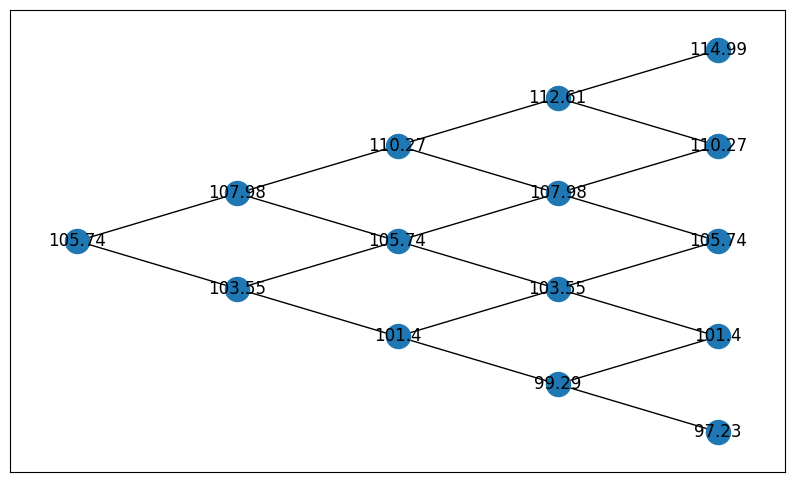

In [41]:
plt.figure(figsize=(10, 6))
posG = {}
labels = {}
i = 0
for node in G.nodes():
    posG[node] = (node[0], N + 2 + node[0] - 2 * node[1])
    i, j = node
    labels[node] = round(S[i][j - 1], 2)
nx.draw_networkx_nodes(G, posG)
nx.draw_networkx_edges(G, posG)
_ = nx.draw_networkx_labels(G, posG, labels)

In [42]:
option_call.get_prob()  # риск-нейтральные вероятности

(0.4968012630484561, 0.5031987369515438)

In [43]:
option_call.get_param()  # параметры u и d

(1.0211977233170073, 0.9792422928165626)

In [44]:
option_put = CRR(S_0, K, r, T, N, sigma, is_call=False, div=div_y, is_european=True)

In [45]:
option_put.get_price()

3.209045490246422

### Паритет пут-колл

In [46]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

108.86736804656562

In [47]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

108.8690497332157

## 5. Модель BSM (Black Scholes Merton)

###  Модель Блэка-Шоулза и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. 

In [48]:
class BSM:
    def __init__(self, S_0, K, r, T, sigma, div=0, t=0, is_call=True):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._sigma = sigma
        self._t = t
        self._is_call = is_call

    def __d_values__(self):
        self._d1 = (
            np.log(self._S_0 / self._K)
            + (self._r - self._div + 0.5 * self._sigma**2) * (self._T - self._t)
        ) / (self._sigma * np.sqrt(self._T - self._t))
        self._d2 = self._d1 - self._sigma * np.sqrt(self._T - self._t)

    def __N_d__(self, d_value):
        return stats.norm.cdf(d_value)

    def __price__(self):
        return (
            (
                np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(self._d1)
                - np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(self._d2)
            )
            if self._is_call
            else (
                np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(-self._d2)
                - np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(-self._d1)
            )
        )

    def get_price(self):
        self.__d_values__()
        price = self.__price__()
        return price

    def get_delta(self):
        self.__d_values__()
        return self.__N_d__(self._d1) if self._is_call else self.__N_d__(self._d1) - 1

    def get_vega(self):
        self.__d_values__()
        return (
            self._S_0
            * stats.norm.pdf(self._d1)
            * np.sqrt(self._T - self._t)
            * np.exp(-self._div * (self._T - self._t))
        ) / 100

### Реализация модели BSM 

In [49]:
K = 105
r = 0.024
sigma = 0.2  # годовое значение
call = True

In [50]:
option_call = BSM(S_0, K, r, T, sigma, div=div_y, is_call=True)

In [51]:
option_call.get_price()

2.1739809537005854

In [52]:
option_call.get_delta()  # дельта опциона

0.5775029306678946

In [53]:
option_call.get_vega()  # вега опциона

0.08674546980516121

In [54]:
option_put = BSM(S_0, K, r, T, sigma, div=div_y, is_call=False)

In [55]:
option_put.get_price()

1.403155234769038

In [56]:
option_put.get_delta()

-0.4224970693321054

In [57]:
option_put.get_vega()

0.08674546980516121

### Паритет пут-колл

In [58]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

107.06315947773831

In [59]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

107.06315947773831

## 5. Опиционные стратегии

###  Bull spread

In [60]:
bull_spread_setup = pd.DataFrame(
    zip(
        ["Call", "Call"],
        [104, 108],
        [
            CRR(
                S_0, 104, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 108, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Sell"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [61]:
bull_spread_setup

,Type,Strike,Price,Buy/Sell
0,Call,104,2.865833,Buy
1,Call,108,0.984652,Sell


In [62]:
bull_spread_result = pd.DataFrame(
    zip(
        range(100, 111),
        np.maximum(range(100, 111) - bull_spread_setup.iloc[0, 1], 0)
        - bull_spread_setup.iloc[0, 2],
        -np.maximum((range(100, 111) - bull_spread_setup.iloc[1, 1]), 0)
        + bull_spread_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call1", "Call2"],
)

In [63]:
bull_spread_result["Result"] = bull_spread_result["Call1"] + bull_spread_result["Call2"]

In [64]:
bull_spread_result

,Spot,Call1,Call2,Result
0,100,-2.865833,0.984652,-1.88118
1,101,-2.865833,0.984652,-1.88118
2,102,-2.865833,0.984652,-1.88118
3,103,-2.865833,0.984652,-1.88118
4,104,-2.865833,0.984652,-1.88118
5,105,-1.865833,0.984652,-0.88118
6,106,-0.865833,0.984652,0.11882
7,107,0.134167,0.984652,1.11882
8,108,1.134167,0.984652,2.11882
9,109,2.134167,-0.015348,2.11882


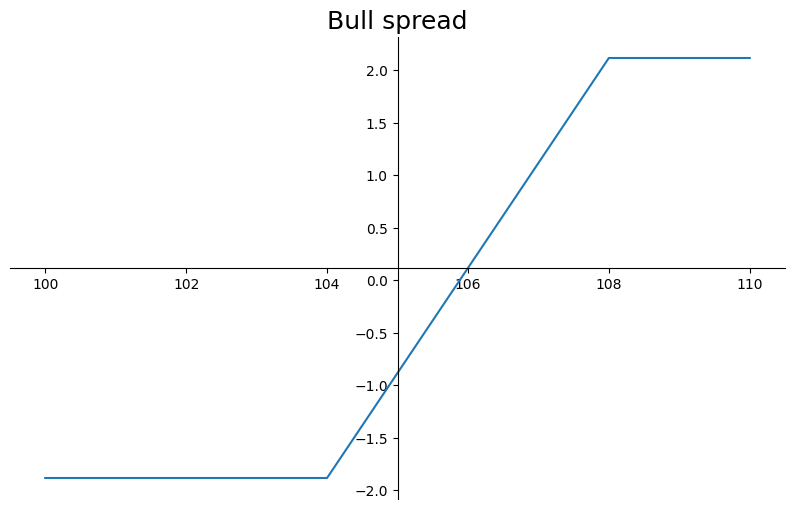

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(bull_spread_result.Spot, bull_spread_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Bull spread", fontsize=18)

###  Long straddle

In [66]:
long_straddle_setup = pd.DataFrame(
    zip(
        ["Call", "Put"],
        [106, 106],
        [
            CRR(
                S_0, 106, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 106, r, T, N, sigma, is_call=False, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Buy"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [67]:
long_straddle_setup

,Type,Strike,Price,Buy/Sell
0,Call,106,1.599122,Buy
1,Put,106,1.833427,Buy


In [68]:
long_straddle_result = pd.DataFrame(
    zip(
        range(100, 111),
        np.maximum(range(100, 111) - long_straddle_setup.iloc[0, 1], 0)
        - long_straddle_setup.iloc[0, 2],
        np.maximum(long_straddle_setup.iloc[1, 1] - (range(100, 111)), 0)
        - long_straddle_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call", "Put"],
)

In [69]:
long_straddle_result["Result"] = (
    long_straddle_result["Call"] + long_straddle_result["Put"]
)

In [70]:
long_straddle_result

,Spot,Call,Put,Result
0,100,-1.599122,4.166573,2.567451
1,101,-1.599122,3.166573,1.567451
2,102,-1.599122,2.166573,0.567451
3,103,-1.599122,1.166573,-0.432549
4,104,-1.599122,0.166573,-1.432549
5,105,-1.599122,-0.833427,-2.432549
6,106,-1.599122,-1.833427,-3.432549
7,107,-0.599122,-1.833427,-2.432549
8,108,0.400878,-1.833427,-1.432549
9,109,1.400878,-1.833427,-0.432549


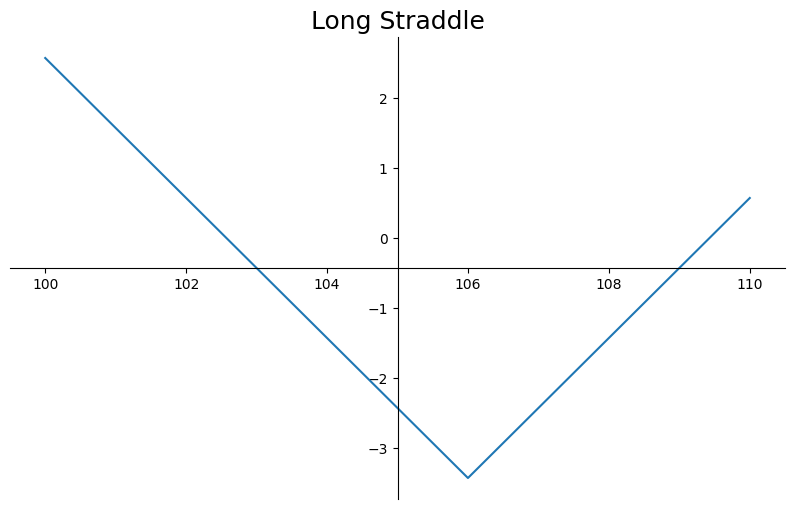

In [71]:
fig = plt.figure(figsize=(10, 6))
plt.plot(long_straddle_result.Spot, long_straddle_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Long Straddle", fontsize=18)

## 6. Сравнение теоретических и рыночных цен

### В данном разделе задания рассчитаем теоретические цены опционов с помощью моделей CRR и BSM  и сравним их с рыночными ценами

In [72]:
N = 1000  # количество шагов для модели CRR

### Call

In [73]:
cboe_MSFT_call["American_div_Bin"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [74]:
cboe_MSFT_call["European_div_Bin"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [75]:
cboe_MSFT_call["BSM_div"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=True
        ).get_price(),
        4,
    ),
    axis=1,
)

In [76]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437,5.2976,5.2976,5.3597
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359,4.4638,4.4638,4.5223
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274,3.6712,3.6712,3.7259
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177,2.9250,2.9250,2.9750
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110,2.2716,2.2716,2.3157
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045,1.6994,1.6994,1.7376
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998,1.2316,1.2316,1.2624
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954,0.8545,0.8545,0.8791
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936,0.5813,0.5813,0.5999
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917,0.3791,0.3791,0.3924


### Put

In [77]:
cboe_MSFT_put["American_div_Bin"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [78]:
cboe_MSFT_put["European_div_Bin"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [79]:
cboe_MSFT_put["BSM_div"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=False
        ).get_price(),
        4,
    ),
    axis=1,
)

In [80]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374,0.4921,0.4918,0.4777
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289,0.6471,0.6468,0.6291
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199,0.8444,0.8439,0.8219
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133,1.1184,1.1176,1.0895
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062,1.4596,1.4585,1.4233
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010,1.8982,1.8966,1.8547
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974,2.4413,2.4390,2.3889
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921,3.0598,3.0565,2.9990
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894,3.7845,3.7800,3.7160
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779,4.5380,4.5314,4.4602


## 7. Показатель чувствительности $\Delta$

###  Delta - hedging. Расчет показателя $\Delta$ приведен в лекционных материалах.

### $C=\Delta S-B$
### $P=\Delta S+B$

### На каждом шаге мы ребалансируем портфель с учетом равенства:
### $dP=\Delta dS$ (для опциона колл расчет аналогичный)
### Ребалансировка учитывает проценты по денежной позиции

### В данном задании будем моделировать динамику актива с помощью геометрического броуновского движения

In [81]:
### $S_{i+1}=S_iexp((r-0.5\sigma^2)\Delta_t+\sigma\sqrt{\Delta_t}Z_t)$

In [82]:
def GBM(n_step, S_0, r, sigma, dt):
    S = np.zeros(n_step)
    S[0] = S_0
    rand = np.random.standard_normal(n_step)
    for i in range(1, n_step):
        S[i] = S[i - 1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[i]
        )
    return S

### Реализуем пошаговый процесс репикации опциона (создания портфеля, воспроизводящего стоимость опциона)

In [83]:
r = 0.0024
T = 20 / 250
sigma = 0.2  # годовое значение
n_step = int(T * 250)
dt = 1 / 250

In [84]:
S = np.zeros(n_step)  # массив цен акци
Delta = np.zeros(n_step)  # массив дельт
Option_theor = np.zeros(n_step)  # массив теоретических цен
S_Delta = np.zeros(n_step)  # произведение цен и дельт
Bond = np.zeros(n_step)  # денежная позиция
Replicate = np.zeros(n_step)  # репликация

### Расчет первоначальных значений параметров

In [85]:
S[0] = S_0

In [86]:
option = BSM(S_0, K, r, T, sigma, t=0, is_call=False)

In [87]:
Option_theor[0] = option.get_price()
Replicate[0] = Option_theor[0]
print(Option_theor[0])

2.01662896918166


In [88]:
Delta[0] = option.get_delta()
S_Delta[0] = S[0] * Delta[0]
print(Delta[0])

-0.43808486478258657


In [89]:
Bond[0] = Option_theor[0] - S_Delta[0]
print(Bond[0])

48.339721695122634


In [90]:
S = GBM(n_step, S_0, r, sigma, dt)  # моделирование динамики

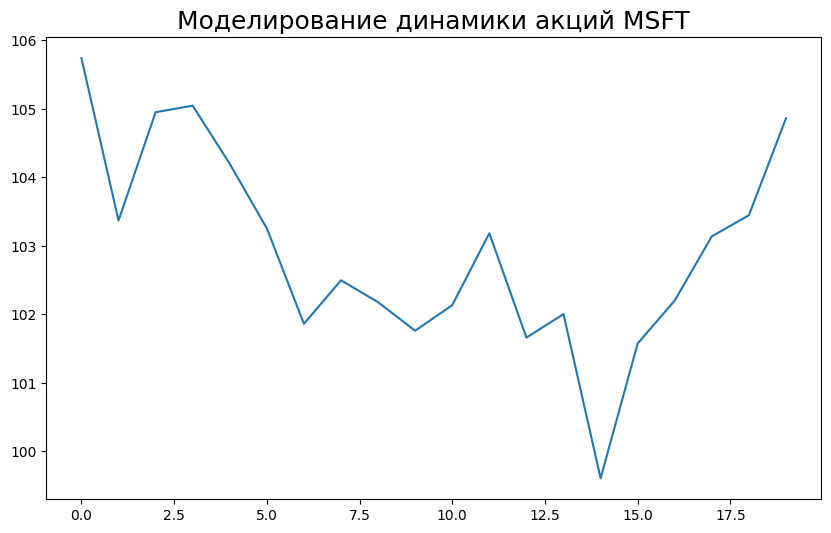

In [91]:
plt.figure(figsize=(10, 6))
_ = plt.plot(S)
_ = plt.title("Моделирование динамики акций MSFT", fontsize=18)

### Пошаговая репликация

In [92]:
for i in range(1, n_step):
    option = BSM(S[i], K, r, T, sigma, is_call=False, t=i / 250)
    Option_theor[i] = option.get_price()
    Delta[i] = option.get_delta()
    S_Delta[i] = S[i] * Delta[i]
    Replicate[i] = (
        Replicate[i - 1]
        + (S[i] - S[i - 1]) * Delta[i - 1]
        + Bond[i - 1] * (np.exp(r / 250) - 1)
    )
    Bond[i] = Option_theor[i] - S_Delta[i]

In [93]:
pd.DataFrame(
    zip(S, Option_theor, Replicate, Delta, S_Delta, Bond),
    columns=["S", "Theor_price", "Replicate", "Delta", "Delta*Price", "Bond"],
).head()

,S,Theor_price,Replicate,Delta,Delta*Price,Bond
0,105.739998,2.016629,2.016629,-0.438085,-46.323093,48.339722
1,103.371174,3.185384,3.054839,-0.599742,-61.996055,65.181439
2,104.952867,2.261553,2.106857,-0.491349,-51.568491,53.830043
3,105.047982,2.152329,2.060639,-0.484857,-50.933288,53.085617
4,104.198360,2.526918,2.473094,-0.549001,-57.205029,59.731947


## 8. Показатель чувствительности Vega

### Расчет показателя vega приведен в лекционных материалах

In [94]:
strikes_range

array([101., 102., 103., 104., 105., 106., 107., 108., 109., 110.])

In [95]:
prices_market = np.array(cboe_MSFT_call.close)

In [96]:
prices_market

array([4.95, 4.25, 3.3 , 2.55, 2.02, 1.39, 0.92, 0.59, 0.38, 0.2 ])

### Нахождение оптимального значения IV методом Ньютона-Рафсона

### $\sigma_{i+1}=\sigma_{i}-\frac{c(\sigma_{i})-c_m}{Vega}$

### Для корректной реализации алгоритма необходимо, чтобы рыночная стоимость была не меньше внутренней стоимости

In [97]:
# Newton-Raphson
T = days / 250
sigma_list = []
tol = 0.001
for strike, price in zip(strikes_range, prices_market):
    if (strike + price) > S_0:
        sigma = 0.3
        diff = 1000
        while diff > tol:
            option = BSM(S_0, strike, r, T, sigma, div=div_y)
            Price_theor = option.get_price()
            Vega = option.get_vega() * 100
            #      print(Price_theor)
            sigma_prev = sigma
            sigma = sigma_prev - (Price_theor - price) / Vega
            diff = abs(price - Price_theor)
        sigma_list.append((strike, sigma))

### Массив значений IV для каждого страйка

In [98]:
sigma_list

[(101.0, 0.19338713126991527),
 (102.0, 0.21508479772770933),
 (103.0, 0.1864732858506528),
 (104.0, 0.1796249780645575),
 (105.0, 0.18868751657554997),
 (106.0, 0.1749088787268799),
 (107.0, 0.16759797351457117),
 (108.0, 0.16447691989576138),
 (109.0, 0.16572616344109453),
 (110.0, 0.15896822216384468)]

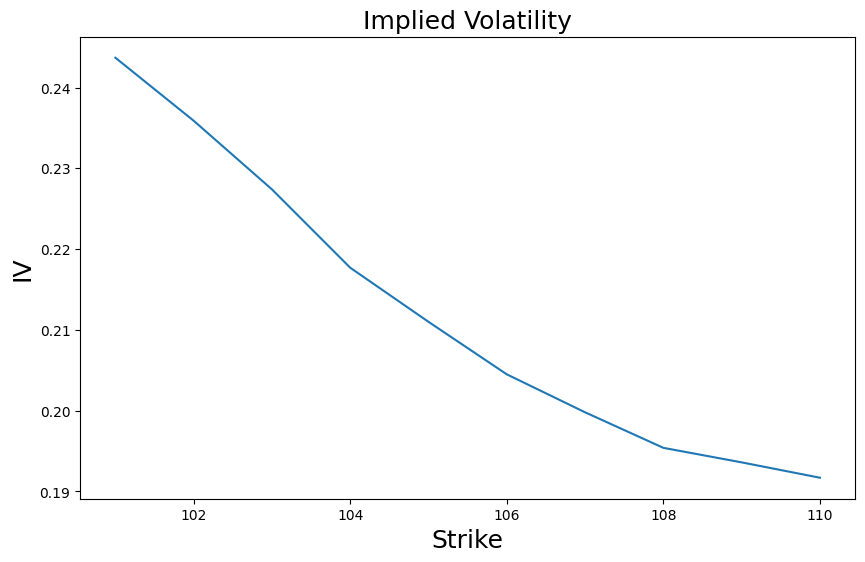

In [99]:
plt.figure(figsize=(10, 6))
_ = plt.plot(cboe_MSFT_call.strike, cboe_MSFT_call.implied_volatility_1545)
_ = plt.xlabel("Strike", fontsize=18)
_ = plt.ylabel("IV", fontsize=18)
_ = plt.title("Implied Volatility", fontsize=18)

### 1. Выбрать для  анализа рынка опционов одну компанию. Для данной компании выбрать одну дату экспирации и сформировать цепочку страйков (примерно 5 страйков в каждую сторону от ATM).
### 2. Рассчитать теоретические стоимости опционов с помощью моделей CRR и BSM и сравнить их с рыночными ценами. 
### 3. Рассчитать параметры для двух опционных стратегий и визуализировать результат
### 4. Провести моделирование динамики цены акции и реализовать процедуру дельта-хеджирования
### 5. Рассчитать показатель IV для цепочки страйков
### 6. Сделать общие выводы по результатам проведенного исследования


## 1. Загрузка библиотек

In [100]:
import numpy as np
import pandas as pd
from scipy import stats

In [101]:
from datetime import datetime, timedelta

In [102]:
from __future__ import division

In [103]:
import networkx as nx  # библиотеке визуализации графов

In [104]:
import matplotlib.pyplot as plt  # графическая библиотека

%matplotlib inline

## 2. Загрузка и подготовка данных

### Данные по опционам

In [105]:
cboe_options = pd.read_csv("UnderlyingOptionsEODCalcs_2019-02-04.csv", parse_dates=True)

In [106]:
cboe_options.columns

Index(['underlying_symbol', 'quote_date', 'root', 'expiration', 'strike',
       'option_type', 'open', 'high', 'low', 'close', 'trade_volume',
       'bid_size_1545', 'bid_1545', 'ask_size_1545', 'ask_1545',
       'underlying_bid_1545', 'underlying_ask_1545',
       'implied_underlying_price_1545', 'active_underlying_price_1545',
       'implied_volatility_1545', 'delta_1545', 'gamma_1545', 'theta_1545',
       'vega_1545', 'rho_1545', 'bid_size_eod', 'bid_eod', 'ask_size_eod',
       'ask_eod', 'underlying_bid_eod', 'underlying_ask_eod', 'vwap',
       'open_interest', 'delivery_code'],
      dtype='object')

In [107]:
cboe_options.head()

,underlying_symbol,quote_date,root,expiration,strike,option_type,open,high,low,close,...,rho_1545,bid_size_eod,bid_eod,ask_size_eod,ask_eod,underlying_bid_eod,underlying_ask_eod,vwap,open_interest,delivery_code
0,AAPL,2019-02-04,AAPL,2019-02-08,100.0,C,0.0,0.0,0.0,0.0,...,0.9958,15,71.05,42,71.40,171.26,171.27,0.0,12,NaN
1,AAPL,2019-02-04,AAPL,2019-02-08,100.0,P,0.0,0.0,0.0,0.0,...,-0.0012,0,0.00,102,0.01,171.26,171.27,0.0,464,NaN
2,AAPL,2019-02-04,AAPL,2019-02-08,105.0,C,0.0,0.0,0.0,0.0,...,1.0550,15,66.05,138,66.50,171.26,171.27,0.0,10,NaN
3,AAPL,2019-02-04,AAPL,2019-02-08,105.0,P,0.0,0.0,0.0,0.0,...,-0.0013,0,0.00,92,0.01,171.26,171.27,0.0,115,NaN
4,AAPL,2019-02-04,AAPL,2019-02-08,110.0,C,0.0,0.0,0.0,0.0,...,1.1147,10,61.10,131,61.50,171.26,171.27,0.0,4,NaN


In [108]:
cboe_options.root.unique()

array(['AAPL', 'MSFT', 'XOM'], dtype=object)

In [109]:
cboe_options.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3260 entries, 0 to 3259
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   underlying_symbol              3260 non-null   object 
 1   quote_date                     3260 non-null   object 
 2   root                           3260 non-null   object 
 3   expiration                     3260 non-null   object 
 4   strike                         3260 non-null   float64
 5   option_type                    3260 non-null   object 
 6   open                           3260 non-null   float64
 7   high                           3260 non-null   float64
 8   low                            3260 non-null   float64
 9   close                          3260 non-null   float64
 10  trade_volume                   3260 non-null   int64  
 11  bid_size_1545                  3260 non-null   int64  
 12  bid_1545                       3260 non-null   f

In [110]:
cboe_options["expiration"] = cboe_options["expiration"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)
### преобразование поля даты в необходимый формат

In [111]:
cboe_options["quote_date"] = cboe_options["quote_date"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d")
)

### Базовый актив

In [112]:
import yfinance as yf

In [113]:
# Input Start and End Date
# start = datetime(2013,12,9)
# end = datetime(2022,9,6)

# xom = yf.download('XOM', interval='1d', start=start, end=end, progress=False, show_errors=False)\
#     .dropna(axis=0)
# xom.to_csv("XOM.csv")   


In [114]:
xom = pd.read_csv("XOM.csv")
xom.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-09 00:00:00-05:00,95.949997,96.250000,95.599998,95.839996,64.983673,15516700
1,2013-12-10 00:00:00-05:00,95.900002,95.980003,95.389999,95.709999,64.895523,9868100
2,2013-12-11 00:00:00-05:00,95.379997,95.540001,94.160004,94.260002,63.912369,12811800
3,2013-12-12 00:00:00-05:00,94.500000,95.879997,94.279999,95.360001,64.658203,15562600
4,2013-12-13 00:00:00-05:00,95.129997,95.919998,94.660004,95.309998,64.624306,10629500


In [115]:
xom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2200 non-null   object 
 1   Open       2200 non-null   float64
 2   High       2200 non-null   float64
 3   Low        2200 non-null   float64
 4   Close      2200 non-null   float64
 5   Adj Close  2200 non-null   float64
 6   Volume     2200 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 120.4+ KB


In [116]:
msft["Date"] = msft["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

TypeError: strptime() argument 1 must be str, not Timestamp

## 3. Выбор опционов для анализа 

In [ ]:
date = "2019-02-04"  # дата расчетов
quote_date = datetime.strptime(date, "%Y-%m-%d")  # дата расчетов
quote_date

datetime.datetime(2019, 2, 4, 0, 0)

In [ ]:
expiration_date = "2019-02-15"  # дата экспирации
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
expiration_date

datetime.datetime(2019, 2, 15, 0, 0)

In [ ]:
# цена спот в дату расчета
S_0 = float(msft[msft.Date == quote_date]["Close"])
print(S_0)

105.739998


In [ ]:
# количество дней до экспирации
days = (expiration_date - quote_date).days
T = days / 250
T

0.044

In [ ]:
div_y = 0.0172  # непрерывная дивидендная ставка (можно взять с сайта yahoo)

In [ ]:
# полный набор страйков
strikes = np.array(
    cboe_options[
        (cboe_options.quote_date == quote_date)
        & (cboe_options.underlying_symbol == "MSFT")
        & (cboe_options.expiration == expiration_date)
    ]["strike"].unique()
)

In [ ]:
strikes

array([ 50. ,  55. ,  60. ,  65. ,  70. ,  75. ,  75.5,  76. ,  76.5,
        77. ,  77.5,  78. ,  78.5,  79. ,  79.5,  80. ,  80.5,  81. ,
        81.5,  82. ,  82.5,  83. ,  83.5,  84. ,  84.5,  85. ,  85.5,
        86. ,  86.5,  87. ,  87.5,  88. ,  88.5,  89. ,  89.5,  90. ,
        90.5,  91. ,  91.5,  92. ,  92.5,  93. ,  94. ,  95. ,  96. ,
        97. ,  97.5,  98. ,  99. ,  99.5, 100. , 101. , 102. , 103. ,
       104. , 105. , 106. , 107. , 108. , 109. , 110. , 111. , 112. ,
       113. , 114. , 115. , 116. , 117. , 118. , 119. , 120. , 125. ,
       130. , 135. , 140. , 145. , 150. ])

In [ ]:
# страйк ATM
index_ATM = np.argmin(np.abs(strikes - S_0))
index_ATM

56

In [ ]:
# вспомогательный индекс для построения списка страйков
strike_range_index = 5

In [ ]:
# максимальный и минимальный индексы для  списка страйков
index_min = max(0, index_ATM - strike_range_index)
index_max = min(len(strikes) - 1, index_ATM + strike_range_index)
print(index_min, index_max)

51 61


In [ ]:
# создание списка страйков
strikes_range = strikes[index_min:index_max]
max(strikes_range)

110.0

In [ ]:
# массив данных по выбранным опционам колл
cboe_MSFT_call = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "MSFT")
    & (cboe_options.option_type == "C")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [ ]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917


In [ ]:
# массив данных по выбранным опционам пут
cboe_MSFT_put = cboe_options[
    (cboe_options.quote_date == quote_date)
    & (cboe_options.underlying_symbol == "MSFT")
    & (cboe_options.option_type == "P")
    & (cboe_options.expiration == expiration_date)
    & (cboe_options.strike <= max(strikes_range))
    & (cboe_options.strike >= min(strikes_range))
][
    [
        "strike",
        "high",
        "low",
        "close",
        "delta_1545",
        "gamma_1545",
        "vega_1545",
        "implied_volatility_1545",
    ]
]

In [ ]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779


## 4. Модель CRR

### Алгоритм  модели биномиального дерева CRR и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. Класс объединяет методы (функции) и переменные или, иначе, реализует механизм инкапсуляции, являющийся важнейшим элементом объектно-ориентированного программирования.

In [ ]:
class CRR:
    def __init__(
        self, S_0, K, r, T, N, sigma, div=0, t=0, is_call=True, is_european=True
    ):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._N = N
        self._sigma = sigma
        self._t = t
        self._is_call = is_call
        self._is_european = is_european

    def __set_up__(self):
        self._dt = T / N
        self._df = np.exp(-(self._r - self._div) * self._dt)
        self._u = np.exp(self._sigma * np.sqrt(self._dt))
        self._d = 1 / self._u
        self._p = (np.exp((self._r - self._div) * self._dt) - self._d) / (
            self._u - self._d
        )
        self._q = 1 - self._p

    def __path_gen__(self):
        self._S = [np.array([self._S_0])]
        for i in range(self._N):
            prev = self._S[-1]
            st = np.concatenate((prev * self._u, [prev[-1] * self._d]))
            self._S.append(st)

    def __initialize_payoffs__(self):
        final_state = self._S[N]
        return (
            np.maximum(0, (final_state - self._K))
            if self._is_call
            else np.maximum(0, (self._K - final_state))
        )

    def __check_early_ex__(self, i, payoffs):
        early_payoffs = (
            (self._S[i] - self._K) if self._is_call else (self._K - self._S[i])
        )
        return np.maximum(early_payoffs, payoffs)

    def __traverse_tree__(self, payoffs):
        for i in reversed(range(self._N)):
            payoffs = (payoffs[:-1] * self._p + payoffs[1:] * self._q) * self._df
            # print(payoffs)
            if not self._is_european:
                payoffs = self.__check_early_ex__(i, payoffs)
        return payoffs

    def get_price(self):
        self.__set_up__()
        self.__path_gen__()
        payoffs_init = self.__initialize_payoffs__()
        payoffs = self.__traverse_tree__(payoffs_init)
        return payoffs[0]

    def get_path(self):
        self.__set_up__()
        self.__path_gen__()
        return self._S

    def get_prob(self):
        self.__set_up__()
        return self._p, self._q

    def get_param(self):
        self.__set_up__()
        return self._u, self._d

### Реализация модели CRR 

In [ ]:
K = 108  # страйк
r = 0.025  # процентная ставка
N = 4  # количестов шагов для построения биномиального дерева
sigma = 0.2  # волатильность

In [ ]:
option_call = CRR(S_0, K, r, T, N, sigma, is_call=True, div=div_y, is_european=True)

In [ ]:
option_call.get_price()

0.9861027305170306

In [ ]:
S = option_call.get_path()  # биномиальное дерево

In [ ]:
S

[array([105.739998]),
 array([107.98144522, 103.54507808]),
 array([110.27040602, 105.739998  , 101.39571967]),
 array([112.60788758, 107.98144522, 103.54507808,  99.29097701]),
 array([114.99491842, 110.27040602, 105.739998  , 101.39571967,
         97.22992399])]

### Визуализация дерева

In [ ]:
G = nx.Graph()

In [ ]:
for i in range(0, N + 1):
    for j in range(1, i + 2):
        if i < N:
            G.add_edge((i, j), (i + 1, j))
            G.add_edge((i, j), (i + 1, j + 1))

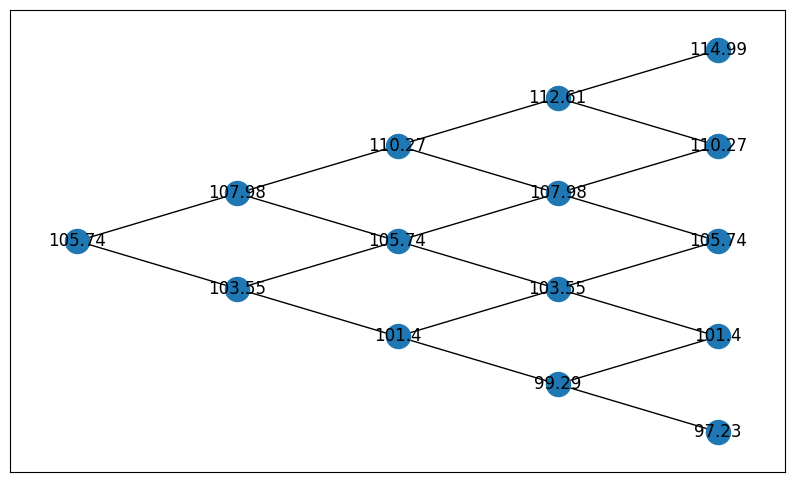

In [ ]:
plt.figure(figsize=(10, 6))
posG = {}
labels = {}
i = 0
for node in G.nodes():
    posG[node] = (node[0], N + 2 + node[0] - 2 * node[1])
    i, j = node
    labels[node] = round(S[i][j - 1], 2)
nx.draw_networkx_nodes(G, posG)
nx.draw_networkx_edges(G, posG)
_ = nx.draw_networkx_labels(G, posG, labels)

In [ ]:
option_call.get_prob()  # риск-нейтральные вероятности

(0.4968012630484561, 0.5031987369515438)

In [ ]:
option_call.get_param()  # параметры u и d

(1.0211977233170073, 0.9792422928165626)

In [ ]:
option_put = CRR(S_0, K, r, T, N, sigma, is_call=False, div=div_y, is_european=True)

In [ ]:
option_put.get_price()

3.209045490246422

### Паритет пут-колл

In [ ]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

108.86736804656562

In [ ]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

108.8690497332157

## 5. Модель BSM (Black Scholes Merton)

###  Модель Блэка-Шоулза и соответствующие формулы приведены в лекционных материалах. Программная реализация модели осуществляется с помощью создания класса. 

In [ ]:
class BSM:
    def __init__(self, S_0, K, r, T, sigma, div=0, t=0, is_call=True):
        self._S_0 = S_0
        self._K = K
        self._r = r
        self._div = div
        self._T = T
        self._sigma = sigma
        self._t = t
        self._is_call = is_call

    def __d_values__(self):
        self._d1 = (
            np.log(self._S_0 / self._K)
            + (self._r - self._div + 0.5 * self._sigma**2) * (self._T - self._t)
        ) / (self._sigma * np.sqrt(self._T - self._t))
        self._d2 = self._d1 - self._sigma * np.sqrt(self._T - self._t)

    def __N_d__(self, d_value):
        return stats.norm.cdf(d_value)

    def __price__(self):
        return (
            (
                np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(self._d1)
                - np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(self._d2)
            )
            if self._is_call
            else (
                np.exp(-self._r * (self._T - self._t))
                * self._K
                * self.__N_d__(-self._d2)
                - np.exp(-self._div * (self._T - self._t))
                * self._S_0
                * self.__N_d__(-self._d1)
            )
        )

    def get_price(self):
        self.__d_values__()
        price = self.__price__()
        return price

    def get_delta(self):
        self.__d_values__()
        return self.__N_d__(self._d1) if self._is_call else self.__N_d__(self._d1) - 1

    def get_vega(self):
        self.__d_values__()
        return (
            self._S_0
            * stats.norm.pdf(self._d1)
            * np.sqrt(self._T - self._t)
            * np.exp(-self._div * (self._T - self._t))
        ) / 100

### Реализация модели BSM 

In [ ]:
K = 105
r = 0.024
sigma = 0.2  # годовое значение
call = True

In [ ]:
option_call = BSM(S_0, K, r, T, sigma, div=div_y, is_call=True)

In [ ]:
option_call.get_price()

2.1739809537005854

In [ ]:
option_call.get_delta()  # дельта опциона

0.5775029306678946

In [ ]:
option_call.get_vega()  # вега опциона

0.08674546980516121

In [ ]:
option_put = BSM(S_0, K, r, T, sigma, div=div_y, is_call=False)

In [ ]:
option_put.get_price()

1.403155234769038

In [ ]:
option_put.get_delta()

-0.4224970693321054

In [ ]:
option_put.get_vega()

0.08674546980516121

### Паритет пут-колл

In [ ]:
K * np.exp(-r * (T - 0)) + option_call.get_price()

107.06315947773831

In [ ]:
np.exp(-div_y * (T - 0)) * S_0 + option_put.get_price()

107.06315947773831

## 5. Опиционные стратегии

###  Bull spread

In [ ]:
bull_spread_setup = pd.DataFrame(
    zip(
        ["Call", "Call"],
        [104, 108],
        [
            CRR(
                S_0, 104, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 108, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Sell"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [ ]:
bull_spread_setup

,Type,Strike,Price,Buy/Sell
0,Call,104,2.865833,Buy
1,Call,108,0.984652,Sell


In [ ]:
bull_spread_result = pd.DataFrame(
    zip(
        range(100, 111),
        np.maximum(range(100, 111) - bull_spread_setup.iloc[0, 1], 0)
        - bull_spread_setup.iloc[0, 2],
        -np.maximum((range(100, 111) - bull_spread_setup.iloc[1, 1]), 0)
        + bull_spread_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call1", "Call2"],
)

In [ ]:
bull_spread_result["Result"] = bull_spread_result["Call1"] + bull_spread_result["Call2"]

In [ ]:
bull_spread_result

,Spot,Call1,Call2,Result
0,100,-2.865833,0.984652,-1.88118
1,101,-2.865833,0.984652,-1.88118
2,102,-2.865833,0.984652,-1.88118
3,103,-2.865833,0.984652,-1.88118
4,104,-2.865833,0.984652,-1.88118
5,105,-1.865833,0.984652,-0.88118
6,106,-0.865833,0.984652,0.11882
7,107,0.134167,0.984652,1.11882
8,108,1.134167,0.984652,2.11882
9,109,2.134167,-0.015348,2.11882


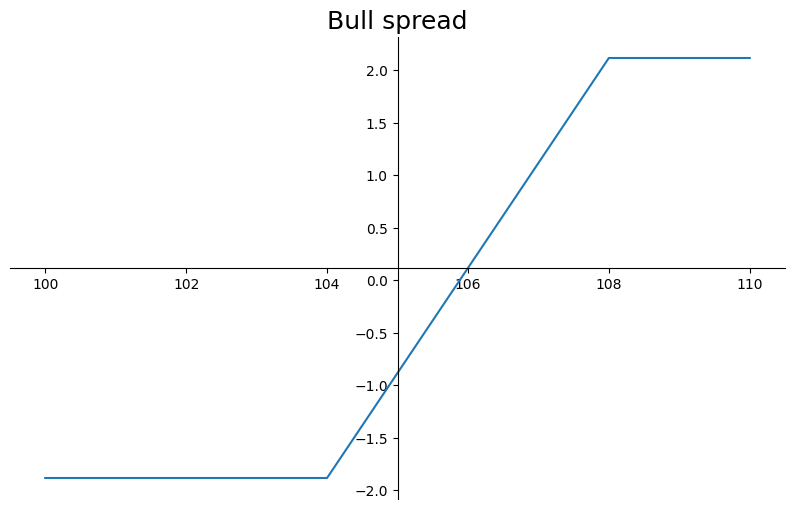

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bull_spread_result.Spot, bull_spread_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Bull spread", fontsize=18)

###  Long straddle

In [ ]:
long_straddle_setup = pd.DataFrame(
    zip(
        ["Call", "Put"],
        [106, 106],
        [
            CRR(
                S_0, 106, r, T, N, sigma, is_call=True, div=div_y, is_european=False
            ).get_price(),
            CRR(
                S_0, 106, r, T, N, sigma, is_call=False, div=div_y, is_european=False
            ).get_price(),
        ],
        ["Buy", "Buy"],
    ),
    columns=["Type", "Strike", "Price", "Buy/Sell"],
)

In [ ]:
long_straddle_setup

,Type,Strike,Price,Buy/Sell
0,Call,106,1.599122,Buy
1,Put,106,1.833427,Buy


In [ ]:
long_straddle_result = pd.DataFrame(
    zip(
        range(100, 111),
        np.maximum(range(100, 111) - long_straddle_setup.iloc[0, 1], 0)
        - long_straddle_setup.iloc[0, 2],
        np.maximum(long_straddle_setup.iloc[1, 1] - (range(100, 111)), 0)
        - long_straddle_setup.iloc[1, 2],
    ),
    columns=["Spot", "Call", "Put"],
)

In [ ]:
long_straddle_result["Result"] = (
    long_straddle_result["Call"] + long_straddle_result["Put"]
)

In [ ]:
long_straddle_result

,Spot,Call,Put,Result
0,100,-1.599122,4.166573,2.567451
1,101,-1.599122,3.166573,1.567451
2,102,-1.599122,2.166573,0.567451
3,103,-1.599122,1.166573,-0.432549
4,104,-1.599122,0.166573,-1.432549
5,105,-1.599122,-0.833427,-2.432549
6,106,-1.599122,-1.833427,-3.432549
7,107,-0.599122,-1.833427,-2.432549
8,108,0.400878,-1.833427,-1.432549
9,109,1.400878,-1.833427,-0.432549


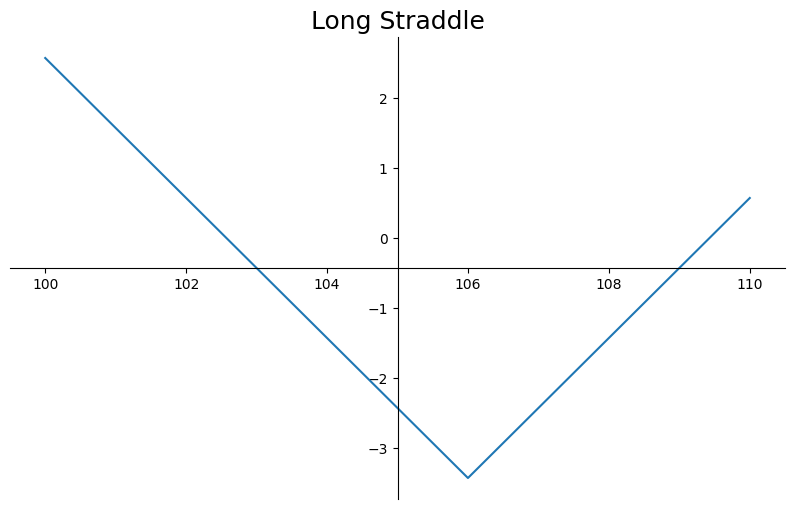

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(long_straddle_result.Spot, long_straddle_result.Result)
ax = plt.gca()
ax.spines["left"].set_position("center")
ax.spines["right"].set_color("none")
ax.spines["bottom"].set_position("center")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.yaxis.set_ticks_position("left")
_ = plt.title("Long Straddle", fontsize=18)

## 6. Сравнение теоретических и рыночных цен

### В данном разделе задания рассчитаем теоретические цены опционов с помощью моделей CRR и BSM  и сравним их с рыночными ценами

In [ ]:
N = 1000  # количество шагов для модели CRR

### Call

In [ ]:
cboe_MSFT_call["American_div_Bin"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_call["European_div_Bin"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=True,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_call["BSM_div"] = cboe_MSFT_call.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=True
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_call

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1654,101.0,5.00,3.85,4.95,0.8507,0.0521,0.0426,0.2437,5.2976,5.2976,5.3597
1656,102.0,4.25,2.44,4.25,0.7973,0.0653,0.0517,0.2359,4.4638,4.4638,4.5223
1658,103.0,3.40,1.85,3.30,0.7307,0.0793,0.0605,0.2274,3.6712,3.6712,3.7259
1660,104.0,2.67,1.25,2.55,0.6500,0.0929,0.0679,0.2177,2.9250,2.9250,2.9750
1662,105.0,2.04,0.61,2.02,0.5538,0.1023,0.0724,0.2110,2.2716,2.2716,2.3157
1664,106.0,1.48,0.60,1.39,0.4490,0.1056,0.0725,0.2045,1.6994,1.6994,1.7376
1666,107.0,1.01,0.39,0.92,0.3438,0.1005,0.0674,0.1998,1.2316,1.2316,1.2624
1668,108.0,0.66,0.29,0.59,0.2464,0.0881,0.0578,0.1954,0.8545,0.8545,0.8791
1670,109.0,0.40,0.18,0.38,0.1669,0.0705,0.0458,0.1936,0.5813,0.5813,0.5999
1672,110.0,0.30,0.09,0.20,0.1056,0.0520,0.0334,0.1917,0.3791,0.3791,0.3924


### Put

In [ ]:
cboe_MSFT_put["American_div_Bin"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=False,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_put["European_div_Bin"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        CRR(
            S_0,
            row["strike"],
            r,
            T,
            N,
            row["implied_volatility_1545"],
            is_call=False,
            div=div_y,
            is_european=True,
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_put["BSM_div"] = cboe_MSFT_put.apply(
    lambda row: np.round(
        BSM(
            S_0, row["strike"], r, T, row["implied_volatility_1545"], is_call=False
        ).get_price(),
        4,
    ),
    axis=1,
)

In [ ]:
cboe_MSFT_put

,strike,high,low,close,delta_1545,gamma_1545,vega_1545,implied_volatility_1545,American_div_Bin,European_div_Bin,BSM_div
1655,101.0,0.65,0.30,0.30,-0.1432,0.0520,0.0414,0.2374,0.4921,0.4918,0.4777
1657,102.0,1.12,0.40,0.40,-0.1960,0.0659,0.0507,0.2289,0.6471,0.6468,0.6291
1659,103.0,1.70,0.57,0.57,-0.2629,0.0810,0.0598,0.2199,0.8444,0.8439,0.8219
1661,104.0,1.88,0.83,0.83,-0.3474,0.0945,0.0677,0.2133,1.1184,1.1176,1.0895
1663,105.0,2.83,1.16,1.20,-0.4452,0.1046,0.0724,0.2062,1.4596,1.4585,1.4233
1665,106.0,3.00,1.60,1.68,-0.5521,0.1074,0.0725,0.2010,1.8982,1.8966,1.8547
1667,107.0,3.15,2.19,2.23,-0.6582,0.1015,0.0673,0.1974,2.4413,2.4390,2.3889
1669,108.0,4.60,2.90,2.90,-0.7575,0.0888,0.0573,0.1921,3.0598,3.0565,2.9990
1671,109.0,3.80,3.80,3.80,-0.8386,0.0705,0.0448,0.1894,3.7845,3.7800,3.7160
1673,110.0,6.45,4.40,4.49,-0.9115,0.0492,0.0294,0.1779,4.5380,4.5314,4.4602


## 7. Показатель чувствительности $\Delta$

###  Delta - hedging. Расчет показателя $\Delta$ приведен в лекционных материалах.

### $C=\Delta S-B$
### $P=\Delta S+B$

### На каждом шаге мы ребалансируем портфель с учетом равенства:
### $dP=\Delta dS$ (для опциона колл расчет аналогичный)
### Ребалансировка учитывает проценты по денежной позиции

### В данном задании будем моделировать динамику актива с помощью геометрического броуновского движения

In [ ]:
### $S_{i+1}=S_iexp((r-0.5\sigma^2)\Delta_t+\sigma\sqrt{\Delta_t}Z_t)$

In [ ]:
def GBM(n_step, S_0, r, sigma, dt):
    S = np.zeros(n_step)
    S[0] = S_0
    rand = np.random.standard_normal(n_step)
    for i in range(1, n_step):
        S[i] = S[i - 1] * np.exp(
            (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand[i]
        )
    return S

### Реализуем пошаговый процесс репикации опциона (создания портфеля, воспроизводящего стоимость опциона)

In [ ]:
r = 0.0024
T = 20 / 250
sigma = 0.2  # годовое значение
n_step = int(T * 250)
dt = 1 / 250

In [ ]:
S = np.zeros(n_step)  # массив цен акци
Delta = np.zeros(n_step)  # массив дельт
Option_theor = np.zeros(n_step)  # массив теоретических цен
S_Delta = np.zeros(n_step)  # произведение цен и дельт
Bond = np.zeros(n_step)  # денежная позиция
Replicate = np.zeros(n_step)  # репликация

### Расчет первоначальных значений параметров

In [ ]:
S[0] = S_0

In [ ]:
option = BSM(S_0, K, r, T, sigma, t=0, is_call=False)

In [ ]:
Option_theor[0] = option.get_price()
Replicate[0] = Option_theor[0]
print(Option_theor[0])

2.01662896918166


In [ ]:
Delta[0] = option.get_delta()
S_Delta[0] = S[0] * Delta[0]
print(Delta[0])

-0.43808486478258657


In [ ]:
Bond[0] = Option_theor[0] - S_Delta[0]
print(Bond[0])

48.339721695122634


In [ ]:
S = GBM(n_step, S_0, r, sigma, dt)  # моделирование динамики

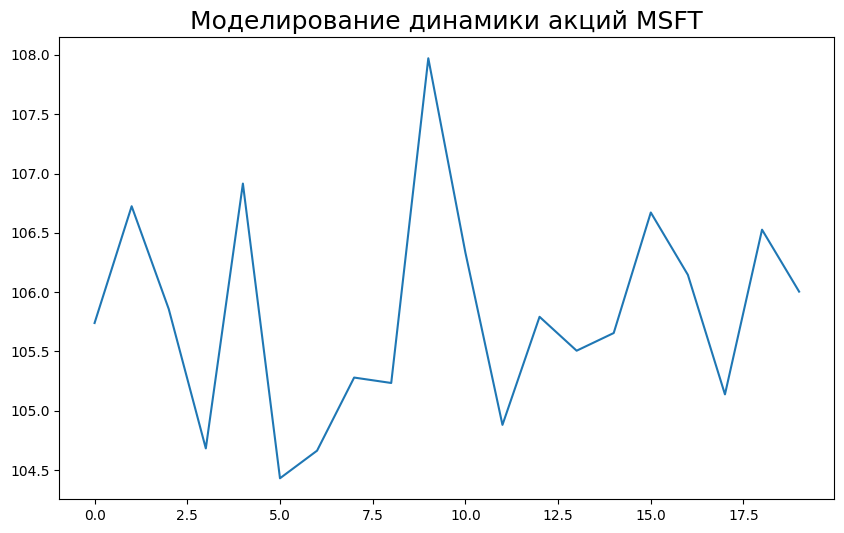

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.plot(S)
_ = plt.title("Моделирование динамики акций MSFT", fontsize=18)

### Пошаговая репликация

In [ ]:
for i in range(1, n_step):
    option = BSM(S[i], K, r, T, sigma, is_call=False, t=i / 250)
    Option_theor[i] = option.get_price()
    Delta[i] = option.get_delta()
    S_Delta[i] = S[i] * Delta[i]
    Replicate[i] = (
        Replicate[i - 1]
        + (S[i] - S[i - 1]) * Delta[i - 1]
        + Bond[i - 1] * (np.exp(r / 250) - 1)
    )
    Bond[i] = Option_theor[i] - S_Delta[i]

In [ ]:
pd.DataFrame(
    zip(S, Option_theor, Replicate, Delta, S_Delta, Bond),
    columns=["S", "Theor_price", "Replicate", "Delta", "Delta*Price", "Bond"],
).head()

,S,Theor_price,Replicate,Delta,Delta*Price,Bond
0,105.739998,2.016629,2.016629,-0.438085,-46.323093,48.339722
1,106.724341,1.559399,1.585867,-0.372096,-39.711721,41.271120
2,105.858042,1.845628,1.908610,-0.427906,-45.297325,47.142953
3,104.683113,2.334090,2.411822,-0.511467,-53.541999,55.876089
4,106.915270,1.309953,1.270683,-0.349897,-37.409346,38.719300


## 8. Показатель чувствительности Vega

### Расчет показателя vega приведен в лекционных материалах

In [ ]:
strikes_range

array([101., 102., 103., 104., 105., 106., 107., 108., 109., 110.])

In [ ]:
prices_market = np.array(cboe_MSFT_call.close)

In [ ]:
prices_market

array([4.95, 4.25, 3.3 , 2.55, 2.02, 1.39, 0.92, 0.59, 0.38, 0.2 ])

### Нахождение оптимального значения IV методом Ньютона-Рафсона

### $\sigma_{i+1}=\sigma_{i}-\frac{c(\sigma_{i})-c_m}{Vega}$

### Для корректной реализации алгоритма необходимо, чтобы рыночная стоимость была не меньше внутренней стоимости

In [ ]:
# Newton-Raphson
T = days / 250
sigma_list = []
tol = 0.001
for strike, price in zip(strikes_range, prices_market):
    if (strike + price) > S_0:
        sigma = 0.3
        diff = 1000
        while diff > tol:
            option = BSM(S_0, strike, r, T, sigma, div=div_y)
            Price_theor = option.get_price()
            Vega = option.get_vega() * 100
            #      print(Price_theor)
            sigma_prev = sigma
            sigma = sigma_prev - (Price_theor - price) / Vega
            diff = abs(price - Price_theor)
        sigma_list.append((strike, sigma))

### Массив значений IV для каждого страйка

In [ ]:
sigma_list

[(101.0, 0.19338713126991527),
 (102.0, 0.21508479772770933),
 (103.0, 0.1864732858506528),
 (104.0, 0.1796249780645575),
 (105.0, 0.18868751657554997),
 (106.0, 0.1749088787268799),
 (107.0, 0.16759797351457117),
 (108.0, 0.16447691989576138),
 (109.0, 0.16572616344109453),
 (110.0, 0.15896822216384468)]

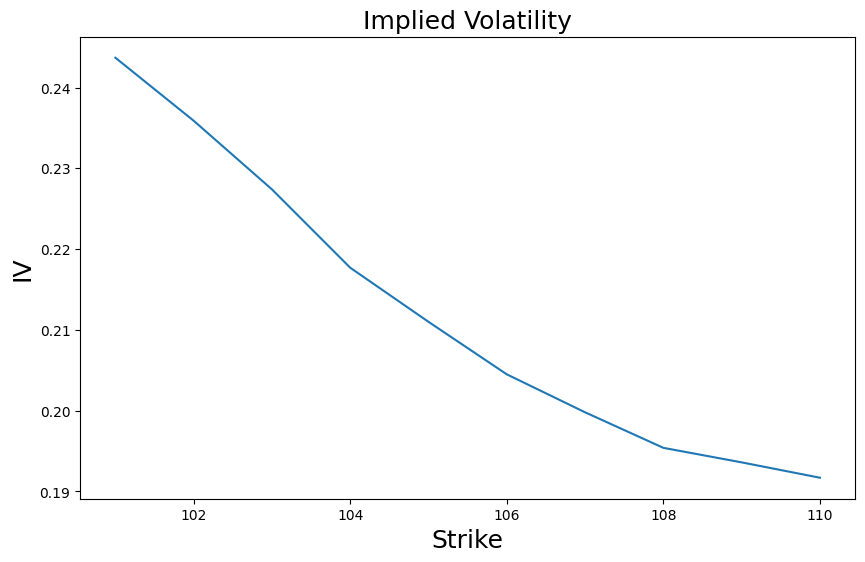

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.plot(cboe_MSFT_call.strike, cboe_MSFT_call.implied_volatility_1545)
_ = plt.xlabel("Strike", fontsize=18)
_ = plt.ylabel("IV", fontsize=18)
_ = plt.title("Implied Volatility", fontsize=18)